# Logistic regression with a neural network mindset: MNIST digits classification

In this project we're going to implement from scratch a one-vs-all logistic regression classifier for the MNIST digits dataset with a neural network mindset. The neural network aspect of this implementation is the use of a forward and backward propagation to claculate the value of the cost function and the partial derivatives of the cost function with respect to weights and the bias, more information in the pdf file.

## Importing and preprocessing data

In [1]:
# Importing necessary libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from scipy.io import loadmat
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Loading MNIST data

mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [3]:
mnist_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [4]:
image_size_px = int(np.sqrt(mnist_data.shape[1]))
image_size_px

28

In [5]:
# Viewing a random MNIST image

def mnist_random_example():
    idx = np.random.randint(70000)
    exp = mnist_data[idx].reshape(image_size_px,image_size_px)
    print("The number in the image below is:", mnist_label[idx])
    plt.imshow(exp)

The number in the image below is: 4.0


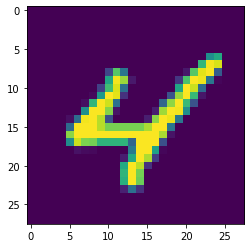

In [6]:
mnist_random_example()

In [7]:
# creating a normalization function

def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std
    return data_normalized

In [8]:
# Normalizing the data

mnist_data_normalized = normalize(mnist_data)

In [9]:
# Splitting the data into Train and Test datasets

X_train, X_test, Y_train, Y_test = train_test_split(mnist_data_normalized, mnist_label, test_size=0.20, random_state=42)
Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)
print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

The shape of the training set feature matrix is: (56000, 784)
The shape of the training label vector is: (56000, 1)
The shape of the test set feature matrix is: (14000, 784)
The shape of the test label vector is: (14000, 1)


In [10]:
# Creating new training label vectors for each digit for the one-vs-all methode

Y_train_0=(Y_train==0).astype(int)
Y_train_1=(Y_train==1).astype(int)
Y_train_2=(Y_train==2).astype(int)
Y_train_3=(Y_train==3).astype(int)
Y_train_4=(Y_train==4).astype(int)
Y_train_5=(Y_train==5).astype(int)
Y_train_6=(Y_train==6).astype(int)
Y_train_7=(Y_train==7).astype(int)
Y_train_8=(Y_train==8).astype(int)
Y_train_9=(Y_train==9).astype(int)

In [11]:
# Creating new testing label vectors for each digit for the one-vs-all methode

Y_test_0=(Y_test==0).astype(int)
Y_test_1=(Y_test==1).astype(int)
Y_test_2=(Y_test==2).astype(int)
Y_test_3=(Y_test==3).astype(int)
Y_test_4=(Y_test==4).astype(int)
Y_test_5=(Y_test==5).astype(int)
Y_test_6=(Y_test==6).astype(int)
Y_test_7=(Y_test==7).astype(int)
Y_test_8=(Y_test==8).astype(int)
Y_test_9=(Y_test==9).astype(int)

## Creating model functions

In [12]:
# Creating initilizer function to initialize weights and bias

def initializer(nbr_features):
    W = np.zeros((nbr_features,1))
    B = 0
    return W, B

In [13]:
# Creating a Sigmoid function

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

In [14]:
# Creating the Forward and backward propagation function which calculates J, dW, and dB

def ForwardBackProp(X, Y, W, B):
    m = X.shape[0] 
    dw = np.zeros((W.shape[0],1))
    dB = 0
    
    Z = np.dot(X,W)+B
    Yhat = sigmoid(Z) 
    J = -(1/m)*(np.dot(Y.T,np.log(Yhat))+np.dot((1-Y).T,np.log(1-Yhat)))
    dW = (1/m)*np.dot(X.T,(Yhat-Y))
    dB = (1/m)*np.sum(Yhat-Y)
    return J, dW, dB

In [15]:
# Creating a prediction function which predicts the labels of the input images

def predict(X,W,B):
    Yhat_prob = sigmoid(np.dot(X,W)+B)
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob

In [16]:
# Creating the gradient descent optimizer function

def gradient_descent(X, Y, W, B, alpha, max_iter):
    i=0
    RMSE = 1
    cost_history=[]
    
    # setup toolbar
    toolbar_width = 20
    sys.stdout.write("[%s]" % ("" * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
    
    while (i<max_iter)&(RMSE>10e-6):
        J, dW, dB = ForwardBackProp(X,Y,W,B)
        W = W - alpha*dW
        B = B - alpha*dB
        cost_history.append(J)
        Yhat, _ = predict(X,W,B)
        RMSE = np.sqrt(np.mean(Yhat-Y)**2)
        i+=1
        if i%50==0:
            sys.stdout.write("=")
            sys.stdout.flush()
    
    sys.stdout.write("]\n") # this ends the progress bar
    return cost_history, W, B, i

In [17]:
# Creating the model function which trains a model and return its parameters. 

def LogRegModel(X_train, X_test, Y_train, Y_test, alpha, max_iter):
    
    nbr_features = X_train.shape[1]
    W, B = initializer(nbr_features)
    cost_history, W, B, i = gradient_descent(X_train, Y_train, W, B, alpha, max_iter)
    Yhat_train, _ = predict(X_train, W, B)
    Yhat, _ = predict(X_test, W, B)
    
    train_accuracy = accuracy_score(Y_train, Yhat_train)
    test_accuracy = accuracy_score(Y_test, Yhat)
    conf_matrix = confusion_matrix(Y_test, Yhat, normalize='true')
    
    model = {"weights": W,
            "bias": B,
            "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy,
            "confusion_matrix": conf_matrix,
            "cost_history": cost_history}
    return model

## Training a test model for the digit "0"

In [18]:
# Testing the model function by training a classifier for the digit '0'

print('Progress bar: 1 step each 50 iteration')
model_0 = LogRegModel(X_train, X_test, Y_train_0, Y_test_0, alpha=0.01, max_iter=1000)
print('Training completed!')

Progress bar: 1 step each 50 iteration
[====================]
Training completed!


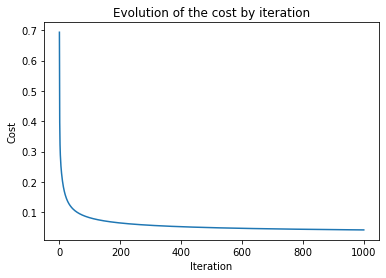

In [19]:
# Viewing the cost evolution over time of the trained model

cost = np.concatenate(model_0['cost_history']).ravel().tolist()
plt.plot(list(range(len(cost))),cost)
plt.title('Evolution of the cost by iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost');

In [20]:
# Checking the accuracy of the model

print('The training accuracy of the model',model_0['train_accuracy'])
print('The test accuracy of the model',model_0['test_accuracy'])

The training accuracy of the model 0.9882321428571429
The test accuracy of the model 0.9875


In [21]:
# Creating a function that shows a random image with the true and predicted label

def check_random_pred(datum,Y,model,label):
    W = model['weights']
    B = model['bias']
    Yhat, _ = predict(datum,W,B)
    if Yhat == 1:
        pred_label = label
    else:
        pred_label = 'Not '+ label
    if Y == 1:
        true_label = label
    else:
        true_label = 'Not '+ label
    print("The number in the image below is:", true_label, ' and predicted as:', pred_label)
    image = datum.reshape(image_size_px,image_size_px)
    plt.imshow(image)

The number in the image below is: Not 0  and predicted as: Not 0


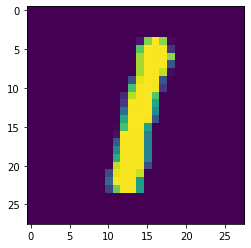

In [22]:
# Checking some random image predictions

idx = np.random.randint(X_test.shape[0])
datum = X_test[idx]
Y = Y_test_0[idx]
check_random_pred(datum,Y,model_0, '0')

## Training a model for each digit

In [23]:
# Creating and training a model for each digit

models_list=[]
models_name_list=['model_0','model_1','model_2','model_3','model_4','model_5','model_6',
                 'model_7','model_8','model_9']
Y_train_list=[Y_train_0,Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5,Y_train_6,
             Y_train_7,Y_train_8,Y_train_9]
Y_test_list = [Y_test_0,Y_test_1,Y_test_2,Y_test_3,Y_test_4,Y_test_5,Y_test_6,Y_test_7,
              Y_test_8,Y_test_9]
print('Training of a classifier for each digit:')
for i in range(10):
    print('Training of the model: ', models_name_list[i],', to recognize the digit: ',i)
    print('Training progress bar: 1 step each 50 iteration')
    model = LogRegModel(X_train, X_test, Y_train_list[i], Y_test_list[i], alpha=0.01, max_iter=1000)
    print('Training completed!')
    print('Accuracy:', model['test_accuracy'])
    print('-'*60)
    models_list.append(model)

Training of a classifier for each digit:
Training of the model:  model_0 , to recognize the digit:  0
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Accuracy: 0.9875
------------------------------------------------------------
Training of the model:  model_1 , to recognize the digit:  1
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Accuracy: 0.9917857142857143
------------------------------------------------------------
Training of the model:  model_2 , to recognize the digit:  2
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Accuracy: 0.9753571428571428
------------------------------------------------------------
Training of the model:  model_3 , to recognize the digit:  3
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Accuracy: 0.9692142857142857
------------------------------------------------------------
Tra

In [24]:
# Calculatin gthe average accuracy of all the models

accuracy_list=[]
for i in range(len(models_list)):
    accuracy_list.append(models_list[i]['test_accuracy'])
ove_vs_all_accuracy=np.mean(accuracy_list)
print('The accuracy of the Onve-Vs-All model is:', ove_vs_all_accuracy)

The accuracy of the Onve-Vs-All model is: 0.9729928571428571


## Final model for digit classification

In [25]:
# Creating a one-vs-all function that uses all the trained models to predict the label of a random image

def one_vs_all(data, models_list):
    pred_matrix = np.zeros((data.shape[0],10))
    for i in range(len(models_list)):
        W = models_list[i]['weights']
        B = models_list[i]['bias']
        Yhat, Yhat_prob = predict(data,W,B)
        pred_matrix[:,i] = Yhat_prob.T
    max_prob_vec = np.amax(pred_matrix, axis=1, keepdims=True)
    pred_matrix_max_prob = (pred_matrix == max_prob_vec).astype(int)
    labels=[]
    for j in range(pred_matrix_max_prob.shape[0]):
        idx = np.where(pred_matrix_max_prob[j,:]==1)
        labels.append(idx)
    labels = np.vstack(labels).flatten()
    return labels

In [26]:
pred_label = one_vs_all(X_test, models_list)
conf_matrix = confusion_matrix(Y_test, pred_label)

def plot_cm(mat,y_ture,ax,case):
    if case == 0:
        df_cm = pd.DataFrame(mat, columns=np.unique(y_ture), index = np.unique(y_ture))
        df_cm.index.name = 'True Label'
        df_cm.columns.name = 'Predicted Label'
        sb.heatmap(df_cm, cmap="Blues", cbar=False, annot=True,annot_kws={"size": 10}, ax=ax)
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
    else:
        l_lab=['Goalkeeper','Defender','Midfielder','Forward']
        df_cm = pd.DataFrame(mat, columns=np.array(l_lab), index = np.unique(l_lab))
        df_cm.index.name = 'True Label'
        df_cm.columns.name = 'Predicted Label'
        sb.heatmap(df_cm, cmap="Blues", cbar=False, annot=True,annot_kws={"size": 10}, ax=ax)
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)

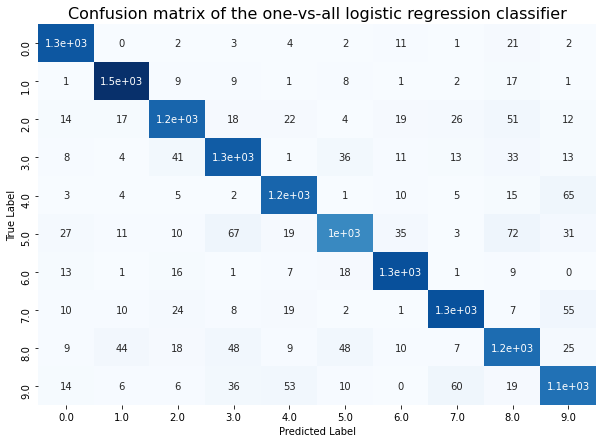

In [27]:
plt.figure(figsize=(10,7))
ax1 = plt.subplot(111)
plt.title('Confusion matrix of the one-vs-all logistic regression classifier', fontsize=16)
plot_cm(conf_matrix, Y_test, ax1,0)

In [28]:
# esting the one-vs-all function on 6 random examples 

examples_number = 6 
index_random_sample = np.random.randint(70000, size=(1,examples_number))
example = mnist_data_normalized[index_random_sample].reshape(examples_number ,784)
true_labels = mnist_label[index_random_sample].flatten().astype(int)
label = one_vs_all(example, models_list)

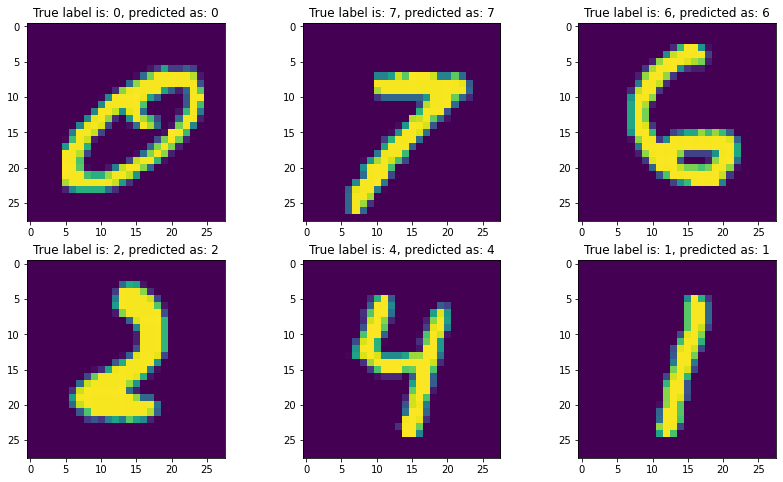

In [29]:
# Viewing results 

plt.figure(figsize=(14,8))
for i in range(examples_number):
    image = example[i].reshape(image_size_px,image_size_px)
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    title = f"True label is: {true_labels[i]}, predicted as: {label[i]}"
    plt.title(title)